No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


E: 100.00259399414062


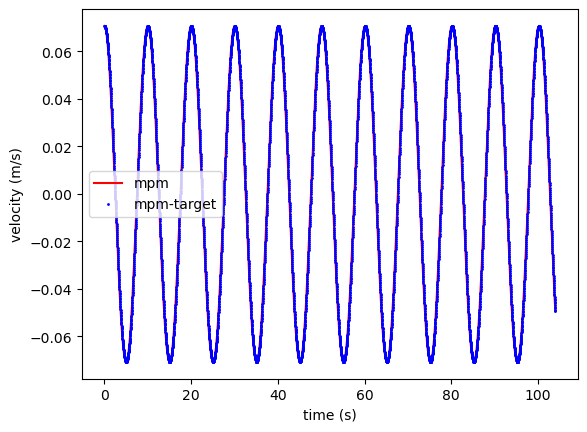

In [2]:

import jax.numpy as jnp
from jax import grad, jit, vmap, lax
import jax.scipy as jsp
import jax.scipy.optimize as jsp_opt
import optax 
import jaxopt
from jaxopt import ScipyBoundedMinimize
import matplotlib.pyplot as plt
import jax

@jit
def mpm(E):
    # nsteps
    nsteps = 5200
    
    # mom tolerance
    tol = 1e-12

    # Domain
    L = 25

    # Material properties
    # E = 100
    rho = 1

    # Computational grid

    nelements = 13 # number of elements
    dx = L / nelements # element length

    # Create equally spaced nodes
    x_n = jnp.linspace(0, L, nelements+1)
    nnodes = len(x_n)

    # Set-up a 2D array of elements with node ids
    elements = jnp.zeros((nelements, 2), dtype = int)
    for nid in range(nelements):
        elements = elements.at[nid,0].set(nid)
        elements = elements.at[nid,1].set(nid+1)

    # Loading conditions
    v0 = 0.1             # initial velocity
    c  = jnp.sqrt(E/rho)  # speed of sound
    b1 = jnp.pi / (2 * L) # beta1
    w1 = b1 * c          # omega1

    # Create material points at the center of each element
    nparticles = nelements  # number of particles
    # Id of the particle in the central element
    pmid = 6

    # Material point properties
    x_p      = jnp.zeros(nparticles)       # positions
    vol_p    = jnp.ones(nparticles) * dx   # volume
    mass_p   = vol_p * rho                 # mass
    stress_p = jnp.zeros(nparticles)       # stress
    vel_p    = jnp.zeros(nparticles)       # velocity

    # Create particle at the center
    x_p      = 0.5 * (x_n[:-1] + x_n[1:])
    
    # set initial velocities
    vel_p    = v0 * jnp.sin(b1 * x_p)
    
    # Time steps and duration
    dt_crit = dx / c
    dt = 0.02
    
    # results
    tt = jnp.zeros(nsteps)
    vt = jnp.zeros(nsteps)
    xt = jnp.zeros(nsteps)

    def step(i, carry):
        x_p, mass_p, vel_p, vol_p, stress_p, vt, xt = carry
        # reset nodal values
        mass_n  = jnp.zeros(nnodes)  # mass
        mom_n   = jnp.zeros(nnodes)  # momentum
        fint_n  = jnp.zeros(nnodes)  # internal force

        # iterate through each element
        for eid in range(nelements):
            # get nodal ids
            nid1, nid2 = elements[eid]

            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[eid] - x_n[nid1])/dx
            N2 = 1 - abs(x_p[eid] - x_n[nid2])/dx
            dN1 = -1/dx
            dN2 = 1/dx

            # map particle mass and momentum to nodes
            mass_n = mass_n.at[nid1].set(mass_n[nid1] + N1 * mass_p[eid])
            mass_n = mass_n.at[nid2].set(mass_n[nid2] + N2 * mass_p[eid])

            mom_n = mom_n.at[nid1].set(mom_n[nid1] + N1 * mass_p[eid] * vel_p[eid])
            mom_n = mom_n.at[nid2].set(mom_n[nid2] + N2 * mass_p[eid] * vel_p[eid])

            # compute nodal internal force
            fint_n = fint_n.at[nid1].set(fint_n[nid1] - vol_p[eid] * stress_p[eid] * dN1)
            fint_n = fint_n.at[nid2].set(fint_n[nid2] - vol_p[eid] * stress_p[eid] * dN2)
        
        # apply boundary conditions
        mom_n = mom_n.at[0].set(0)  # Nodal velocity v = 0 in m * v at node 0.
        fint_n = fint_n.at[0].set(0)  # Nodal force f = m * a, where a = 0 at node 0.

        # update nodal momentum
        mom_n = mom_n + fint_n * dt

        # update particle velocity position and stress
        # iterate through each element
        for eid in range(nelements):
            # get nodal ids
            nid1, nid2 = elements[eid]

            # compute shape functions and derivatives
            N1 = 1 - abs(x_p[eid] - x_n[nid1])/dx
            N2 = 1 - abs(x_p[eid] - x_n[nid2])/dx
            dN1 = -1/dx
            dN2 = 1/dx

            # compute particle velocity
            # if (mass_n[nid1]) > tol:
            vel_p = vel_p.at[eid].set(vel_p[eid] + dt * N1 * fint_n[nid1] / mass_n[nid1])
            # if (mass_n[nid2]) > tol:
            vel_p = vel_p.at[eid].set(vel_p[eid] + dt * N2 * fint_n[nid2] / mass_n[nid2])

            # update particle position based on nodal momentum
            x_p = x_p.at[eid].set(x_p[eid] + dt * (N1 * mom_n[nid1]/mass_n[nid1] + N2 * mom_n[nid2]/mass_n[nid2]))

            # nodal velocity
            nv1 = mom_n[nid1]/mass_n[nid1]
            nv2 = mom_n[nid2]/mass_n[nid2]

             # rate of strain increment
            grad_v = dN1 * nv1 + dN2 * nv2
            # particle dstrain
            dstrain = grad_v * dt
            # particle volume
            vol_p = vol_p.at[eid].set((1 + dstrain) * vol_p[eid])
            # update stress using linear elastic model
            stress_p = stress_p.at[eid].set(stress_p[eid] + E * dstrain)

        # results
        vt = vt.at[i].set(vel_p[pmid])
        xt = xt.at[i].set(x_p[pmid])

        return (x_p, mass_p, vel_p, vol_p, stress_p, vt, xt)

    x_p, mass_p, vel_p, vol_p, stress_p, vt, xt = lax.fori_loop(0, nsteps, step, (x_p, mass_p, vel_p, vol_p, stress_p, vt, xt))


    return vt


# Assign target
Etarget = 100
target = mpm(Etarget)


#############################################################
#  NOTE: Uncomment the line only for TFP optimizer and 
#        jaxopt value_and_grad = True
#############################################################
# @jax.value_and_grad
@jit
def compute_loss(E):
    vt = mpm(E)
    return jnp.linalg.norm(vt - target)

# BFGS Optimizer
# TODO: Implement box constrained optimizer
def jaxopt_bfgs(params, niter):
  opt= jaxopt.BFGS(fun=compute_loss, value_and_grad=True, tol=1e-5, implicit_diff=False, maxiter=niter)
  res = opt.run(init_params=params)
  result, _ = res
  return result

# Optimizers
def optax_adam(params, niter):
  # Initialize parameters of the model + optimizer.
  start_learning_rate = 1e-1
  optimizer = optax.adam(start_learning_rate)
  opt_state = optimizer.init(params)

  # A simple update loop.
  for _ in range(niter):
    grads = grad(compute_loss)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
  return params
  
# Tensor Flow Probability Optimization library
def tfp_lbfgs(params):
  results = tfp.optimizer.lbfgs_minimize(
        jax.jit(compute_loss), initial_position=params, tolerance=1e-5)
  return results.position

# Initial model - Young's modulus 
params = 95.0

# vt = tfp_lbfgs(params)               # LBFGS optimizer
result = optax_adam(params, 1000)     # ADAM optimizer

"""
f = jax.jit(compute_loss)
df = jax.jit(jax.grad(compute_loss))
E = 95.0
print(0, E)
for i in range(10):
    E = E - f(E)/df(E)
    print(i, E)
"""
print("E: {}".format(result))
vel = mpm(result)
# update time steps
dt = 0.02
nsteps = 5200
tt = jnp.arange(0, nsteps) * dt

# Plot results
plt.plot(tt, vel, 'r', markersize=1, label='mpm')
plt.plot(tt, target, 'ob', markersize=1, label='mpm-target')
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

In [3]:
result

Array(100.002594, dtype=float32)